In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

path = '/content/drive/MyDrive/EVA6/s10_TinyImagenet/'

In [3]:
% cd $path

/content/drive/MyDrive/EVA6/s10_TinyImagenet


In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [5]:
#!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
#!unzip 'annotations_trainval2017.zip'

In [6]:


src_file= open('annotations/instances_train2017.json')





In [7]:

# Reading the json file

data = json.load(src_file)

data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [8]:
data['images'][0]

{'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'date_captured': '2013-11-14 11:18:45',
 'file_name': '000000391895.jpg',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'height': 360,
 'id': 391895,
 'license': 3,
 'width': 640}

In [9]:
data['annotations'][2]

{'area': 5607.661349999996,
 'bbox': [239.48, 347.87, 160.0, 57.81],
 'category_id': 58,
 'id': 603,
 'image_id': 200365,
 'iscrowd': 0,
 'segmentation': [[274.58,
   405.68,
   298.32,
   405.68,
   302.45,
   402.58,
   333.42,
   404.65,
   356.13,
   397.42,
   386.06,
   386.06,
   398.45,
   367.48,
   399.48,
   356.13,
   392.26,
   347.87,
   382.97,
   350.97,
   339.61,
   357.16,
   283.87,
   365.42,
   269.42,
   367.48,
   243.61,
   362.32,
   239.48,
   368.52,
   241.55,
   374.71,
   253.94,
   381.94,
   267.35,
   385.03,
   271.48,
   394.32,
   271.48,
   399.48,
   272.52,
   400.52,
   281.81,
   404.65]]}

In [10]:
n_images = len(data['images'])
n_boxes = len(data['annotations'])
n_categ = len(data['categories'])

# height, width
heights = [x['height'] for x in data['images']]
widths = [x['width'] for x in data['images']]




print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Number of images:  118287
Number of bounding boxes:  860001
Number of classes:  80
Max min avg height:  640 51 484
Max min avg width:  640 59 577


#### Distribution of objects across images

In [11]:

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in data['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


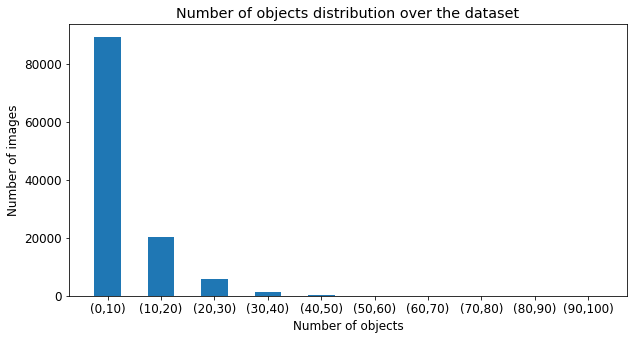

Number of images having atleast one box:  117266
Min number of boxes per image:  1
Max number of boxes per image:  93
Avg number of boxes per image:  7


In [12]:
out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

### Map Class names to Category ids

In [13]:
categ_map = {}
for cat in data['categories']:
  cat_id = cat['id']
  cat_name = cat['name']

  categ_map[cat_id] = cat_name

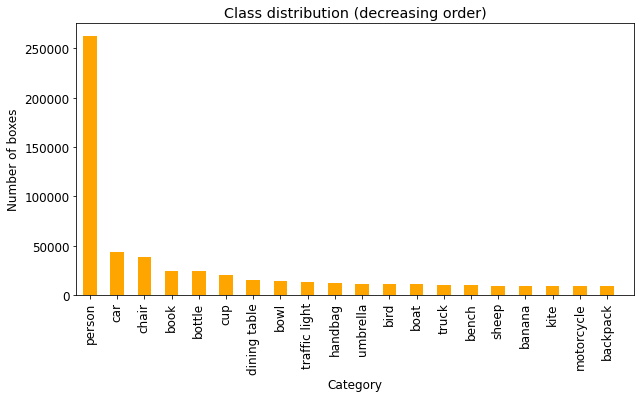

In [14]:
# Class distribution
class2nboxes = {} 

for ann in data['annotations']:
    cat_id = ann['category_id']
    cat_name = categ_map[cat_id]
    
    if cat_name in class2nboxes.keys():
        class2nboxes[cat_name] += 1
    else:
        class2nboxes[cat_name] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xticks(rotation=90) 
plt.xlim(-0.5,len(y))
plt.xlabel('Category')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()

In [15]:
class_data = []
for k in categ_map.keys():
  class_data.append([k, categ_map[k]])

coco_class_df = pd.DataFrame(class_data, columns=["class_id", "class_name"])
coco_class_df.head()

,class_id,class_name
0,1,person
1,2,bicycle
2,3,car
3,4,motorcycle
4,5,airplane


#### Prepare data for K-Means Clustering¶

In [16]:
images_df = pd.DataFrame(data['images'], columns = data['images'][0].keys())
images_df=images_df.dropna()
annotations_df = pd.DataFrame(data['annotations'], columns = data['annotations'][0].keys())
annotations_df.dropna()

,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,"[[239.97, 260.24, 222.04, 270.49, 199.84, 253....",2765.14865,0,558840,"[199.84, 200.46, 77.71, 70.88]",58,156
1,"[[247.71, 354.7, 253.49, 346.99, 276.63, 337.3...",1545.42130,0,200365,"[234.22, 317.11, 149.39, 38.55]",58,509
2,"[[274.58, 405.68, 298.32, 405.68, 302.45, 402....",5607.66135,0,200365,"[239.48, 347.87, 160.0, 57.81]",58,603
3,"[[296.65, 388.33, 296.65, 388.33, 297.68, 388....",0.00000,0,200365,"[296.65, 388.33, 1.03, 0.0]",58,918
4,"[[251.87, 356.13, 260.13, 343.74, 300.39, 335....",800.41325,0,200365,"[251.87, 333.42, 125.94, 22.71]",58,1072
...,...,...,...,...,...,...,...
859996,"{'counts': [13254, 1, 316, 4, 6, 1, 315, 7, 31...",4227.00000,1,390883,"[40, 104, 394, 43]",1,900100390883
859997,"{'counts': [68786, 6, 492, 9, 494, 7, 497, 4, ...",6058.00000,1,49902,"[137, 195, 140, 138]",53,905300049902
859998,"{'counts': [203528, 6, 420, 8, 418, 10, 416, 1...",737.00000,1,363764,"[476, 200, 153, 85]",43,904300363764
859999,"{'counts': [99015, 6, 352, 8, 350, 9, 322, 11,...",6478.00000,1,554743,"[275, 207, 153, 148]",1,900100554743


In [17]:
# #Extract the Box Dimensions
annotation_map_df = pd.concat([images_df, annotations_df], 1)[['file_name', 'width', 'height', 'bbox']]
box_df =pd.DataFrame(annotation_map_df['bbox'].values.tolist(), columns =['x', 'y', 'box_width', 'box_height'])
annotation_map_df = pd.concat([annotation_map_df, box_df], 1)
annotation_map_df = annotation_map_df.drop('bbox', axis =1)

In [18]:
annotation_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,199.84,200.46,77.71,70.88
1,000000522418.jpg,640.0,480.0,234.22,317.11,149.39,38.55
2,000000184613.jpg,500.0,336.0,239.48,347.87,160.00,57.81
3,000000318219.jpg,556.0,640.0,296.65,388.33,1.03,0.00
4,000000554625.jpg,426.0,640.0,251.87,333.42,125.94,22.71


In [19]:

#Normalize the Box Dimensions based on Image Height and Width
annotation_map_df['x'] = annotation_map_df['x'] / annotation_map_df['width']
annotation_map_df['y'] = annotation_map_df['y'] / annotation_map_df['height']
annotation_map_df['box_width'] = annotation_map_df['box_width'] / annotation_map_df['width']
annotation_map_df['box_height'] = annotation_map_df['box_height'] / annotation_map_df['height']
annotation_map_df=annotation_map_df.dropna()

In [20]:
annotation_map_df.head()

,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,0.312250,0.556833,0.121422,0.196889
1,000000522418.jpg,640.0,480.0,0.365969,0.660646,0.233422,0.080312
2,000000184613.jpg,500.0,336.0,0.478960,1.035327,0.320000,0.172054
3,000000318219.jpg,556.0,640.0,0.533543,0.606766,0.001853,0.000000
4,000000554625.jpg,426.0,640.0,0.591244,0.520969,0.295634,0.035484


In [21]:
hw_array = annotation_map_df[["box_width", "box_height"]].to_numpy()
hw_array.shape

(118287, 2)

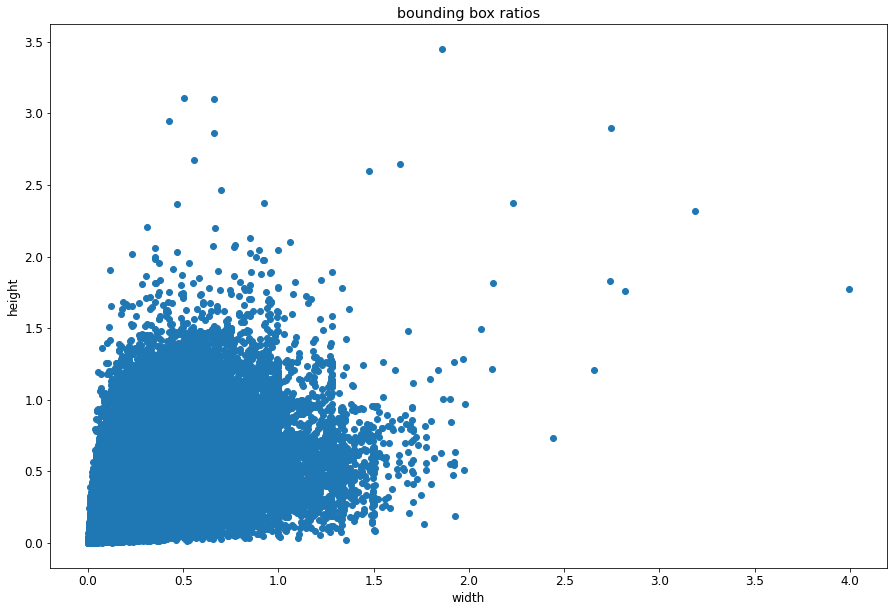

In [22]:

plt.figure(figsize=(15, 10))

plt.scatter(hw_array[:,0], hw_array[:,1])
plt.xlabel("width")
plt.ylabel("height")
plt.title("bounding box ratios")
plt.show()


Applying KMeans to find optimal number of clusters

Using the WCSS/elbow method to find the optimal number of clusters:

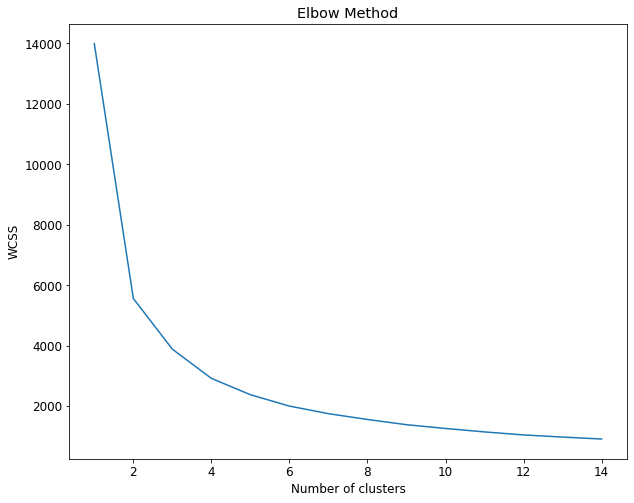

In [23]:
from sklearn.cluster import KMeans
wcss = []
for c in range(1, 15):
    kmeans = KMeans(
        n_clusters=c,
        init='k-means++',
        max_iter=300,
        n_init=10,
        random_state=0
    )
    kmeans.fit(hw_array)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


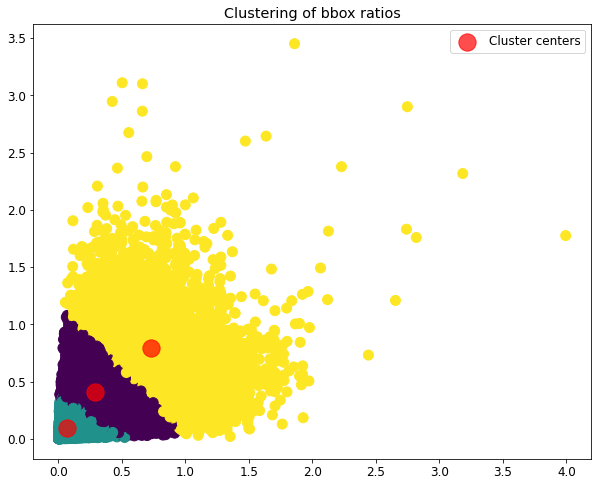

In [24]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(hw_array)

plt.figure(figsize=(10, 8))
plt.scatter(hw_array[:,0], hw_array[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()

In [25]:
kmeans.cluster_centers_

array([[0.2895797 , 0.41005067],
       [0.07200435, 0.09480068],
       [0.72981024, 0.79292409]])

When K=3

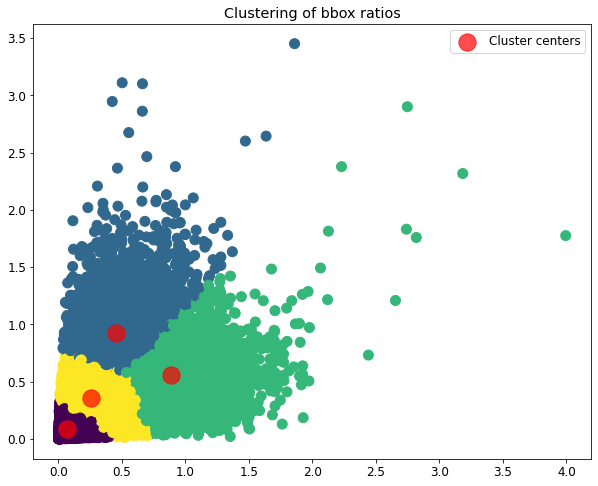

In [26]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(hw_array)

plt.figure(figsize=(10, 8))
plt.scatter(hw_array[:,0], hw_array[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()

when k=5

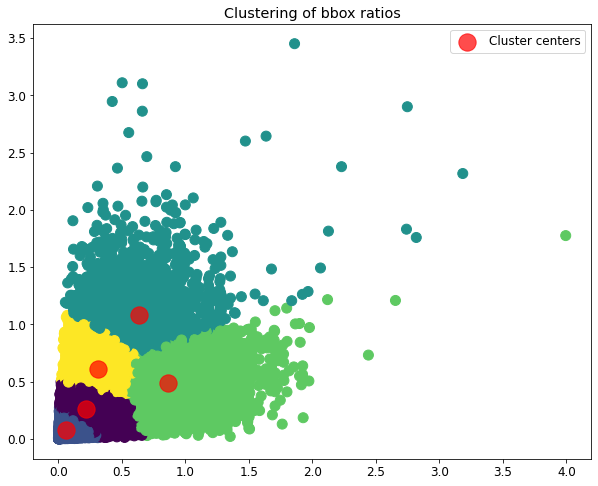

In [27]:
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(hw_array)

plt.figure(figsize=(10, 8))
plt.scatter(hw_array[:,0], hw_array[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()

when k=6

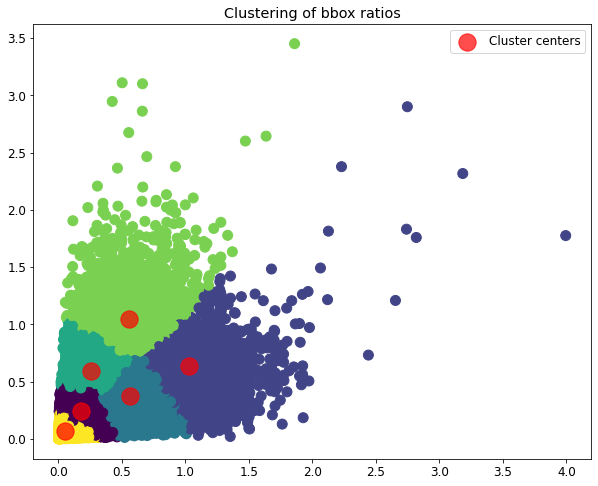

In [28]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(hw_array)

plt.figure(figsize=(10, 8))
plt.scatter(hw_array[:,0], hw_array[:,1], c=pred_y, s=100)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, alpha=.7, c='r', label="Cluster centers")
plt.title('Clustering of bbox ratios')
plt.legend()
plt.show()

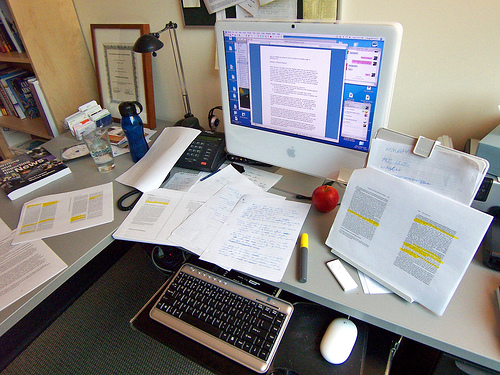

In [29]:
from PIL import Image
import requests
#Image.open(os.path.join(path, "images", "000000391895.jpg"))
url="http://images.cocodataset.org/train2017/000000451053.jpg"
#Image.open("http://images.cocodataset.org/train2017/000000451053.jpg",stream=True)
Image.open(requests.get(url, stream=True).raw)

In [30]:
annotation_map_df.head(3)


,file_name,width,height,x,y,box_width,box_height
0,000000391895.jpg,640.0,360.0,0.312250,0.556833,0.121422,0.196889
1,000000522418.jpg,640.0,480.0,0.365969,0.660646,0.233422,0.080312
2,000000184613.jpg,500.0,336.0,0.478960,1.035327,0.320000,0.172054
